# 1 Import library and dataset

## 1.1 Import library

In [1]:
# Import Libraries 
import torch 
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from sklearn.model_selection import train_test_split
from statistics import stdev, mean
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
%matplotlib inline

## 1.2 Data import

In [2]:
# Define import transformation 
trans = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
trainset = torchvision.datasets.MNIST(root = './data', train = True, transform = trans, download=True)
validset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
num_train = len(trainset)
valid_size = 0.2
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
print('split size:',split)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

split size: 12000


In [5]:
# Load datasets 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, sampler=valid_sampler)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1000,shuffle=True)

In [6]:
# Example Data
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

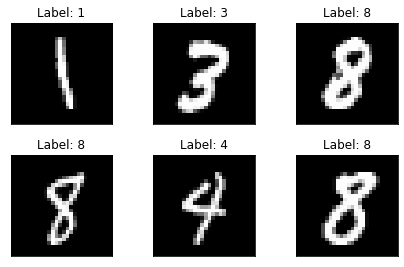

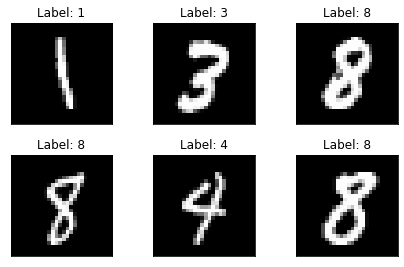

In [7]:
# Data visulalization 
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# 2 Buildinbg model and training functions

### Recomended Structure

- Conv2d (1->16 channels, kernel: 3x3, stride: 1, padding: 1)   
- ReLU( )  
- MaxPool (2x2)  
- Conv2d (16->4 channels, kernel: 3x3, stride: 1, padding: 1)  
- ReLU( )  
- MaxPool (2x2)  
- Linear (196, 10)  
- Softmax( )

In [8]:
class NET(nn.Module):
  def __init__(self):
    super(NET, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1)
    self.fc1   = nn.Linear(196, 10)
    self.pool  = nn.MaxPool2d(2,2)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 196)
    x = self.fc1(x)
    x  = F.log_softmax(x, dim=1)
    return x
  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)  

## 2.2 Training function

In [9]:
def fit(model:NET,epochs=3, lr=0.001, step_size=10):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  # print('learning rate:',lr)
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader):     
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      running_loss += loss.item()
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i % step_size == 0: 
        train_loss.append(running_loss/step_size)
        running_loss = 0.0
        v_loss, v_acc = valid_eval(mlp)
        val_loss.append(v_loss)
        val_acc.append(v_acc) 
  
  return train_loss, val_loss, val_acc

## 2.3 Evaluation functions

In [10]:
def test_eval(model:NET):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for i, data in enumerate(testloader, 0):
      inputs, labels = data
      outputs = model(inputs)
      test_loss += criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
  test_loss /= len(testloader.dataset)
  test_accs = (100. * correct / len(testloader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  return test_loss, test_accs

In [11]:
def valid_eval(model:NET):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for i, data in enumerate(validloader, 0):
      inputs, labels = data
      outputs = model(inputs)
      val_loss += criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
  val_loss /= split
  val_acc = (100. * correct / split)
  # print('Valid set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
  #   val_loss, correct, split,
  #   100. * correct / split))
  return val_loss, val_acc

# Model Summary

In [12]:
mlp = NET()
total_parameters = mlp.count_parameters()
print('Total Number of parameters',total_parameters)
summary(mlp, (1, 28, 28))

Total Number of parameters 2710
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3            [-1, 4, 14, 14]             580
         MaxPool2d-4              [-1, 4, 7, 7]               0
            Linear-5                   [-1, 10]           1,970
Total params: 2,710
Trainable params: 2,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


# 3 Train and evaluate the model

## 3.1 Traing the CNN using ADAM optimizer and analays the training and validation loss. Verify the performance of the network using test set

In [13]:
# Parameter setup 
learning_rate = 0.01
epochs = 3
step_size = 200 # inverval steps for logging the loss and accuracy 
criterion = nn.NLLLoss()

In [14]:
mlp = NET()
test_eval(mlp)
train_loss, val_loss, val_acc = fit(mlp, lr=0.01)
test_eval(mlp)


Test set: Avg. loss: 0.0023, Accuracy: 894/10000 (9%)


Test set: Avg. loss: 0.0001, Accuracy: 9701/10000 (97%)



(tensor(9.9031e-05), 97.01)

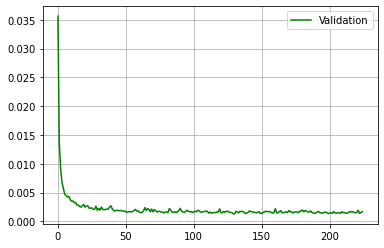

In [15]:
# plt.plot(train_loss, color='r')
plt.plot(val_loss, color='g', label='Validation')
plt.legend()
plt.grid()
plt.show()

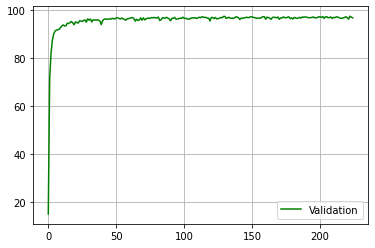

In [16]:
plt.plot(val_acc, color='g', label='Validation')
plt.legend()
plt.grid()
plt.show()

## 3.2 Experiment 2: Identify mean, $\mu$ and standrd deviation $\sigma$ the training loss and accuracy

In [18]:
def fit2(model:NET,epochs=1, lr=0.001, step_size=1, break_size = 10, seed_no=0):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  # print('learning rate:',lr)
  torch.manual_seed(seed_no)
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader):     
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      running_loss += loss.item()
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i % step_size == 0: 
        train_loss.append(running_loss/step_size)
        running_loss = 0.0
        v_loss, v_acc = valid_eval(mlp)
        val_loss.append(v_loss)
        val_acc.append(v_acc) 
      
      if i == break_size: break
  
  return train_loss, val_loss, val_acc

In [20]:
# Parameter setup 
learning_rate = 0.0001
epochs = 1
criterion = nn.NLLLoss()
seeds = [1,20, 58, 94]
train_losses =[]
val_losses=[]
val_accs=[]
break_size = 25

for seed in seeds:
  print('Seed no:',seed)
  mlp = NET()
  tring_loss, val_loss, val_acc = fit2(mlp, epochs=epochs, lr=learning_rate, seed_no=seed, break_size=break_size)
  train_losses.append(tring_loss)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Seed no: 1
Seed no: 20
Seed no: 58
Seed no: 94


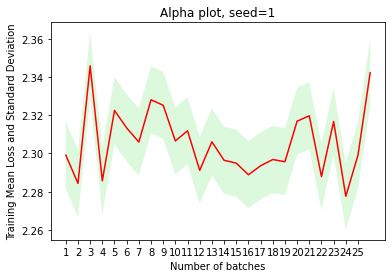

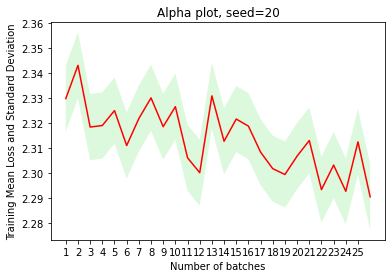

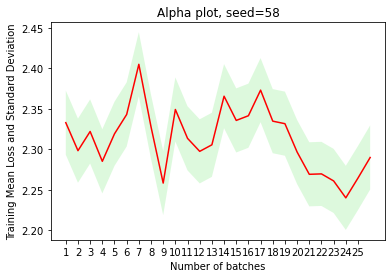

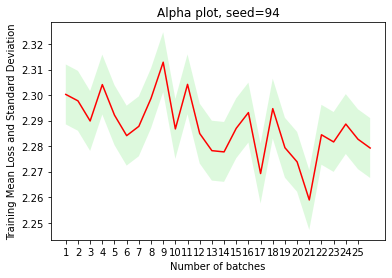

In [21]:
t = np.arange(1, break_size+2)
tel = np.array(train_losses[0])
tel_std_up = tel + stdev(tel)
tel_std_down = tel - stdev(tel)

fig, ax = plt.subplots()
ax.plot(t, tel, color='red')
ax.fill_between(t, tel_std_up, tel_std_down, facecolor='lightgreen', alpha=0.3)
ax.set_title('Alpha plot, seed=1')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Training Mean Loss and Standard Deviation')
ax.set_xticks(np.arange(1, break_size+1))
plt.show()

t = np.arange(1, break_size+2)
tel = np.array(train_losses[1])
tel_std_up = tel + stdev(tel)
tel_std_down = tel - stdev(tel)

fig, ax = plt.subplots()
ax.plot(t, tel, color='red')
ax.fill_between(t, tel_std_up, tel_std_down, facecolor='lightgreen', alpha=0.3)
ax.set_title('Alpha plot, seed=20')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Training Mean Loss and Standard Deviation')
ax.set_xticks(np.arange(1, break_size+1))
plt.show()

t = np.arange(1, break_size+2)
tel = np.array(train_losses[2])
tel_std_up = tel + stdev(tel)
tel_std_down = tel - stdev(tel)

fig, ax = plt.subplots()
ax.plot(t, tel, color='red')
ax.fill_between(t, tel_std_up, tel_std_down, facecolor='lightgreen', alpha=0.3)
ax.set_title('Alpha plot, seed=58')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Training Mean Loss and Standard Deviation')
ax.set_xticks(np.arange(1, break_size+1))
plt.show()

t = np.arange(1, break_size+2)
tel = np.array(train_losses[3])
tel_std_up = tel + stdev(tel)
tel_std_down = tel - stdev(tel)

fig, ax = plt.subplots()
ax.plot(t, tel, color='red')
ax.fill_between(t, tel_std_up, tel_std_down, facecolor='lightgreen', alpha=0.3)
ax.set_title('Alpha plot, seed=94')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Training Mean Loss and Standard Deviation')
ax.set_xticks(np.arange(1, break_size+1))
plt.show()

# Experiment 3: Trying with differnt step size with Adam optimizer

In [23]:
# Parameter setup 
step_sizes = [0.00001, 0.0001, 0.001, 0.01, 0.05]
epochs = 1
step_size = 100 # inverval steps for logging the loss and accuracy 
criterion = nn.NLLLoss()

# Iteration number
val_losses=[]
val_accs=[]
for lr in step_sizes:
  print('Learning rate:',lr)
  mlp = NET()
  _, val_loss, val_acc = fit(mlp, epochs=epochs, lr=lr)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Learning rate: 1e-05
Learning rate: 0.0001
Learning rate: 0.001
Learning rate: 0.01
Learning rate: 0.05


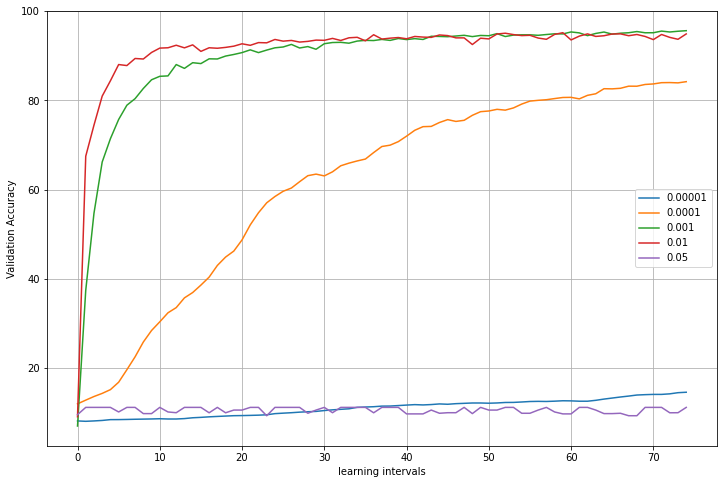

In [24]:
fig= plt.figure(figsize=(12,8))
plt.xlabel('learning intervals')
plt.ylabel('Validation Accuracy')
plt.plot(val_accs[0], label='0.00001')
plt.plot(val_accs[1], label='0.0001')
plt.plot(val_accs[2], label='0.001')
plt.plot(val_accs[3], label='0.01')
plt.plot(val_accs[4], label='0.05')
plt.legend()
plt.grid()
plt.show()

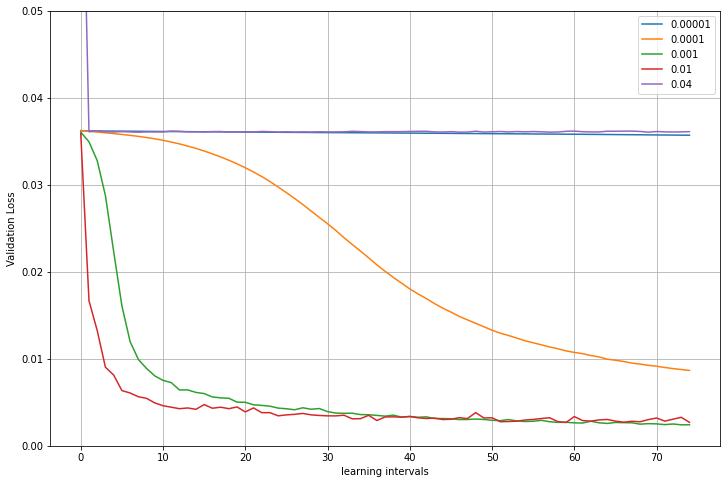

In [25]:
fig= plt.figure(figsize=(12,8))
plt.xlabel('learning intervals')
plt.ylabel('Validation Loss')
plt.ylim([.0, 0.05])
plt.plot(val_losses[0], label='0.00001')
plt.plot(val_losses[1], label='0.0001')
plt.plot(val_losses[2], label='0.001')
plt.plot(val_losses[3], label='0.01')
plt.plot(val_losses[4], label='0.04')
plt.legend()
plt.grid()
plt.show()